# Analyse ENMs
The title of the notebook should be coherent with file name. Namely, file name should be:    
*author's initials_progressive number_title.ipynb*    
For example:    
*EF_01_Data Exploration.ipynb*

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import glob
from biopandas.pdb import PandasPdb
from pymol import cmd

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import seaborn as sns

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

### Change directory
If Jupyter lab sets the root directory in `notebooks`, change directory.

In [2]:
if "notebook" in os.getcwd():
    os.chdir("..")

## Local library import
We import all the required local libraries libraries

In [3]:
# Include local library paths
import sys
sys.path.append("./src") # uncomment and fill to import local libraries

# Import local libraries
import src.utilities as utils

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [89]:
config = utils.read_config()
# PATHS
EIGENVALUES_PATH="tmp/eigenvalues.csv"
EIGENVECTORS_PATH="tmp/eigenvectors.csv"
DIST_PATH="tmp/dist.csv"

# PLOTS
plt.style.use(config['viz']['default'])


# Data import
We retrieve all the required data for the analysis.

In [30]:
eigenvals = pd.read_csv(EIGENVALUES_PATH, sep=',', header=0, index_col='mode_number')
eigenvecs = pd.read_csv(EIGENVECTORS_PATH, sep=',', header=0, index_col='mode_number')
dist = np.loadtxt(DIST_PATH, delimiter=',')

# Data processing
Put here the core of the notebook. Feel free to further split this section into subsections.

In [37]:
no_beads = eigenvecs['bead_number'].nunique()
bead_idxs = np.arange(no_beads)

In [101]:
mode_number = 7
eigenval = eigenvals[eigenvals.index== mode_number]['eigenvalue']
eigenvec = eigenvecs[eigenvecs.index == mode_number][['x_comp', 'y_comp', 'z_comp']].to_numpy()

In [102]:
# Calculate pairwise dot product
if dist.shape[0] != eigenvec.shape[0]:
    print("Check eigenvector and distance files.")

dotprod = np.zeros((no_beads, no_beads))

for i in np.arange(no_beads):
    for j in np.arange(i+1):
        vector_1 = eigenvec[i]
        vector_2 = eigenvec[j]
        # vector_1 = vector_1 / np.linalg.norm(vector_1)
        # vector_2 = vector_2 / np.linalg.norm(vector_2)

        dotprod[i][j] = np.dot(vector_1, vector_2)

dotprod = dotprod + np.triu(dotprod.T, k=1)

In [103]:
# Tom's correlation function
corr = np.zeros(no_beads)
for i in np.arange(no_beads):
    mask = np.ones(no_beads, dtype=bool)
    # Mask diagonal value
    mask[i] = False
    dotprod_i = dotprod[i][mask]
    dist_i = dist[i][mask]
    corr[i] = np.sum((dotprod_i - dotprod[i,i]) / (dist_i * dotprod[i,i]))

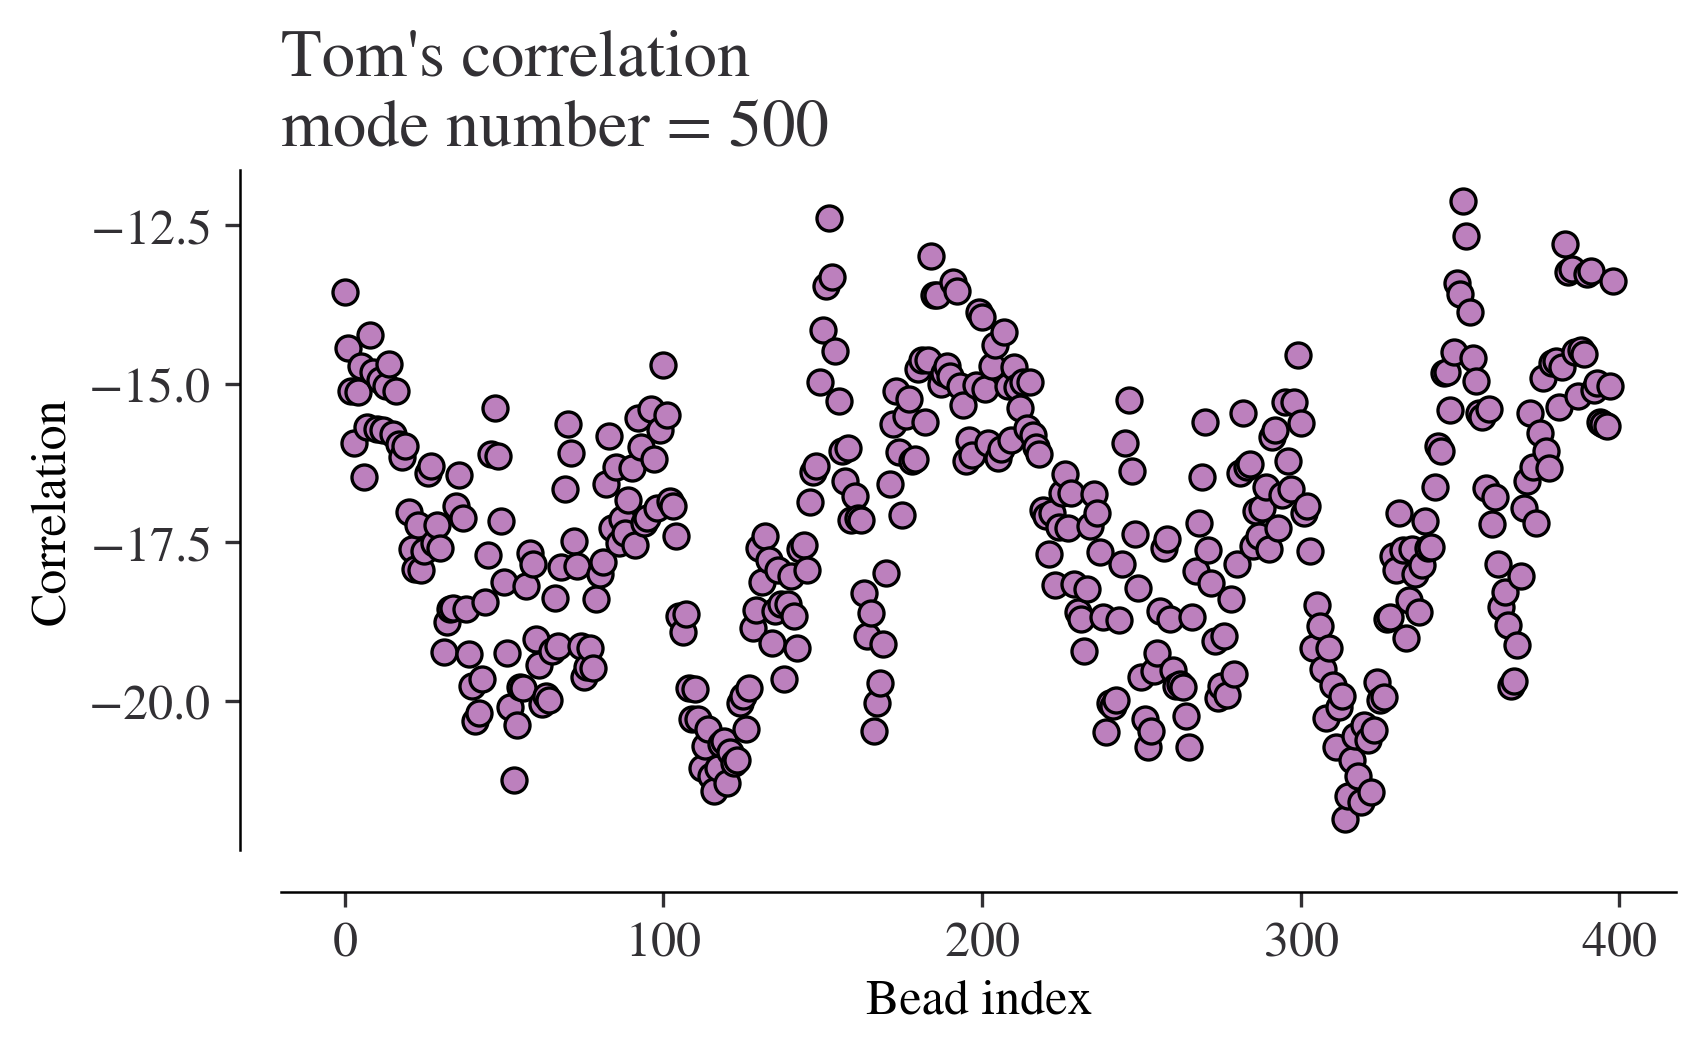

In [104]:
fig, ax = plt.subplots()
ax.scatter(bead_idxs, corr)
ax.set_xlabel("Bead index")
ax.set_ylabel("Correlation")
ax.set_title("Tom's correlation\nmode number = {}".format(mode_number))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_position(('outward', 10))
ax.margins(0.05, 0.05)

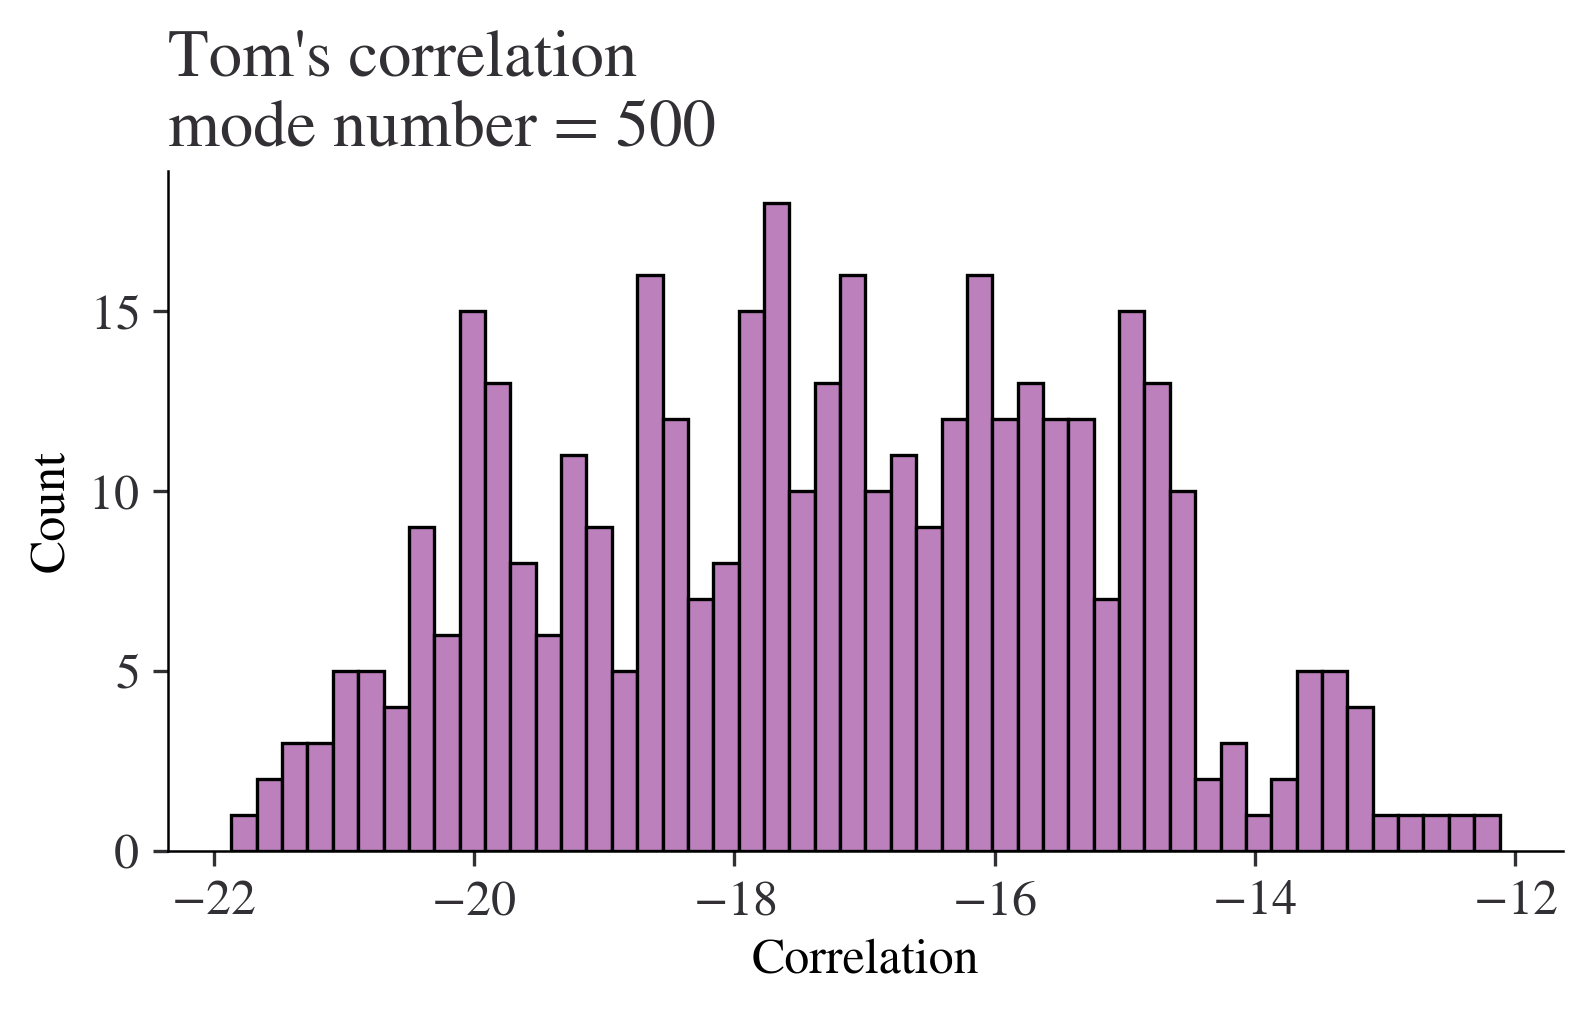

In [105]:
fig, ax = plt.subplots()
ax.hist(corr, bins=50, density=False, edgecolor="k")
ax.set_title("Tom's correlation\nmode number = {}".format(mode_number))
ax.set_xlabel("Correlation")
ax.set_ylabel("Count")
# ax.spines['bottom'].set_position(('outward', 10))
# ax.spines['left'].set_position(('outward', 10))
ax.margins(0.05, 0.05)

In [106]:
dist_flat = dist[np.triu_indices(no_beads, k = 1)]
dotprod_flat = dotprod[np.triu_indices(no_beads, k = 1)]
X = pd.DataFrame(data=np.vstack((dist_flat, dotprod_flat)).T, columns=['distance', 'dot_product'])

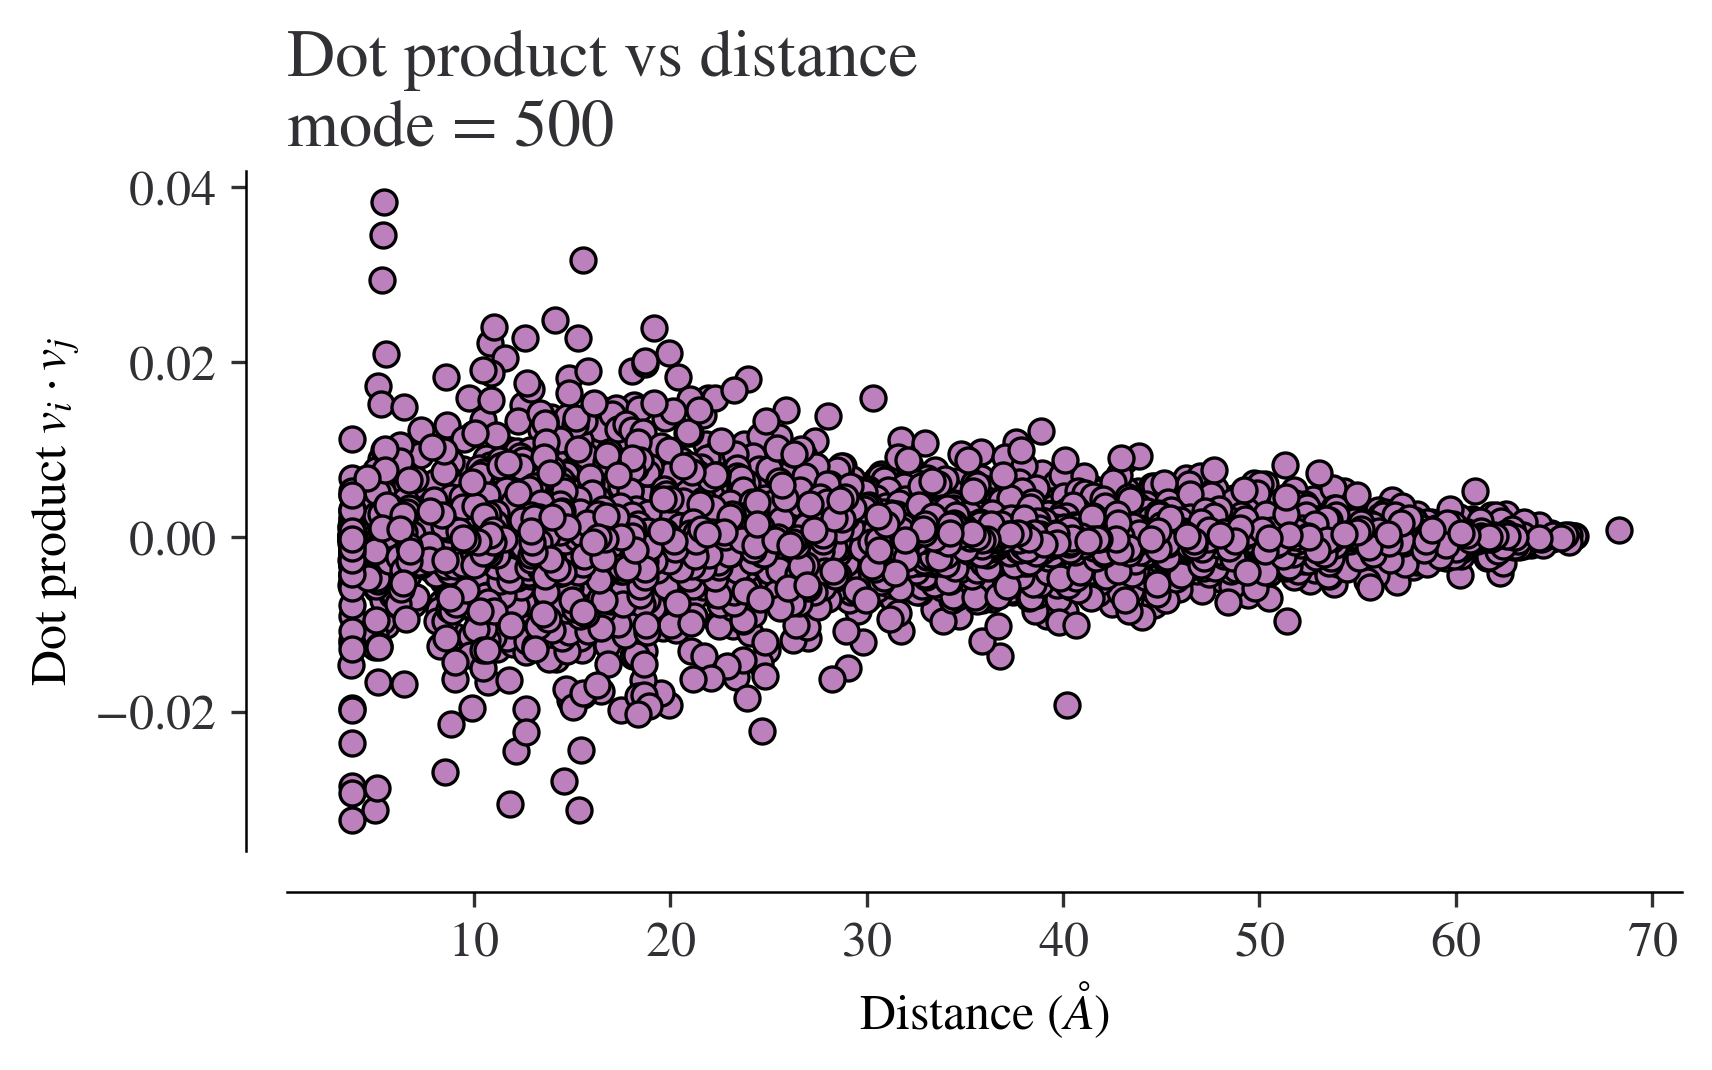

In [107]:
fig, ax = plt.subplots()
ax.scatter(dist_flat, dotprod_flat)
ax.set_xlabel("Distance ($\AA$)")
ax.set_ylabel("Dot product $v_i \cdot v_j$")
ax.set_title("Dot product vs distance\nmode = {}".format(mode_number))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_position(('outward', 10))
ax.margins(0.05, 0.05)

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2